A1: [[2.50656748e-46 3.59338927e-45 1.89129258e-44 ... 1.90702443e-42
  4.81837744e-42 1.14599476e-41]
 [1.17762859e-43 6.53434644e-43 2.61928779e-42 ... 1.58952351e-40
  3.55873996e-40 7.45083377e-40]
 [4.55107657e-41 1.93000833e-40 6.43253887e-40 ... 2.48888859e-38
  5.06975490e-38 9.68351813e-38]
 ...
 [1.96785570e-38 1.23574371e-37 5.47183518e-37 ... 4.35374060e-35
  1.02080369e-34 2.22107927e-34]
 [6.19028421e-41 5.34303037e-40 2.94105248e-39 ... 3.67986185e-37
  9.43382448e-37 2.22803320e-36]
 [1.60178709e-43 1.99739154e-42 1.41272356e-41 ... 2.79897122e-39
  7.94803099e-39 2.07046968e-38]]
A2: [[ 2.50656748e-46 -1.78630705e-36  1.02614869e-36 ... -5.75086257e-26
  -6.68013806e-25  3.02201851e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
  

<Figure size 1500x1000 with 0 Axes>

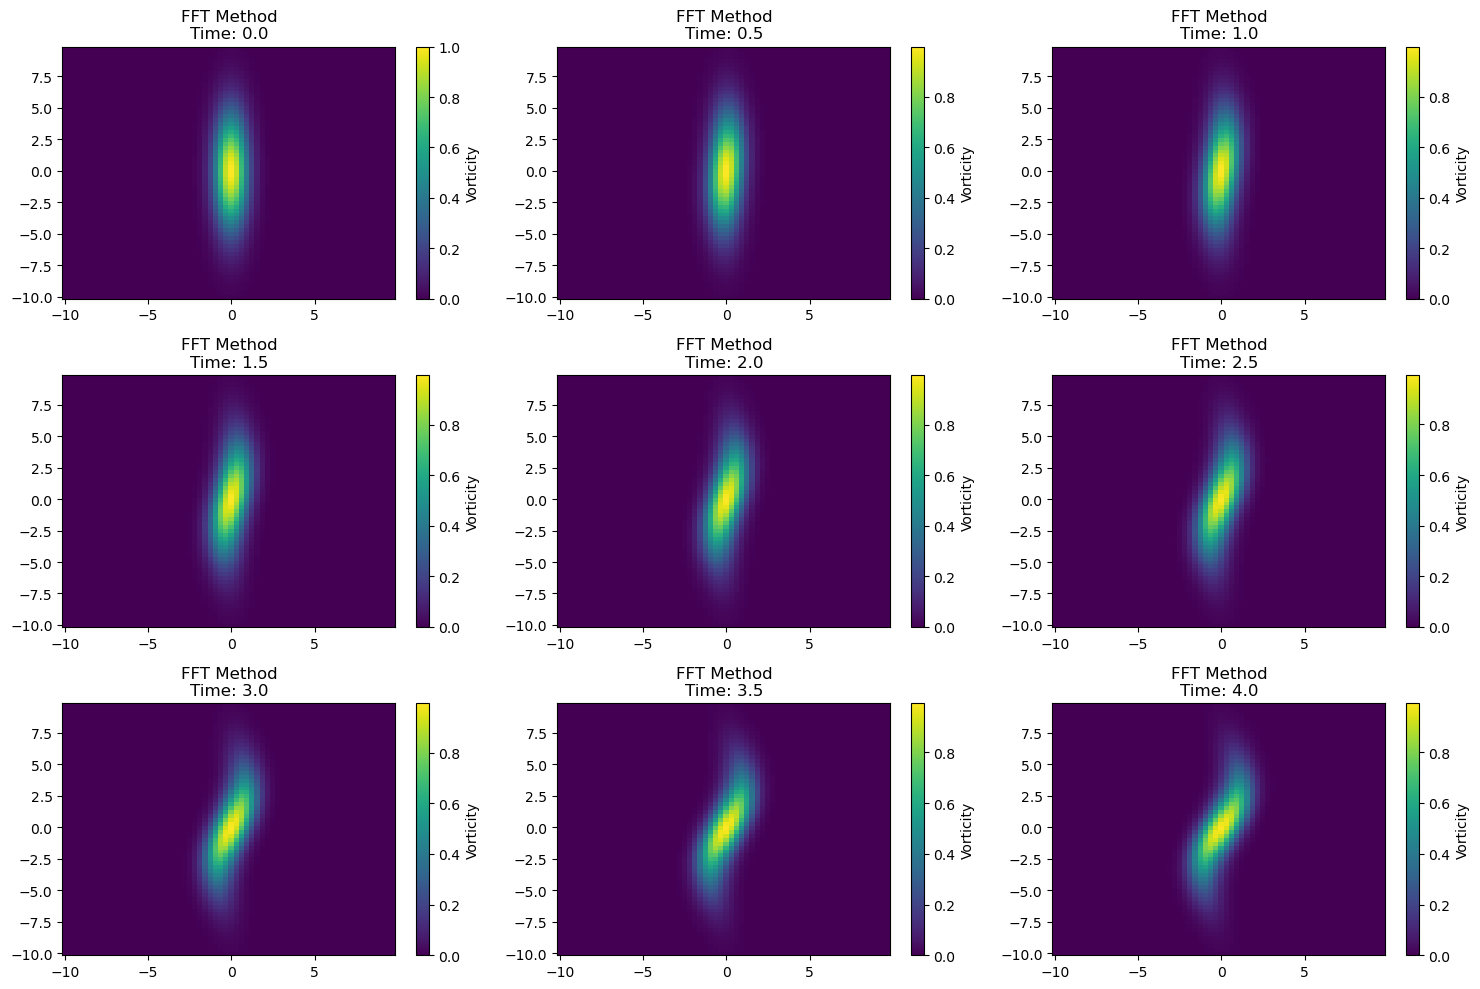

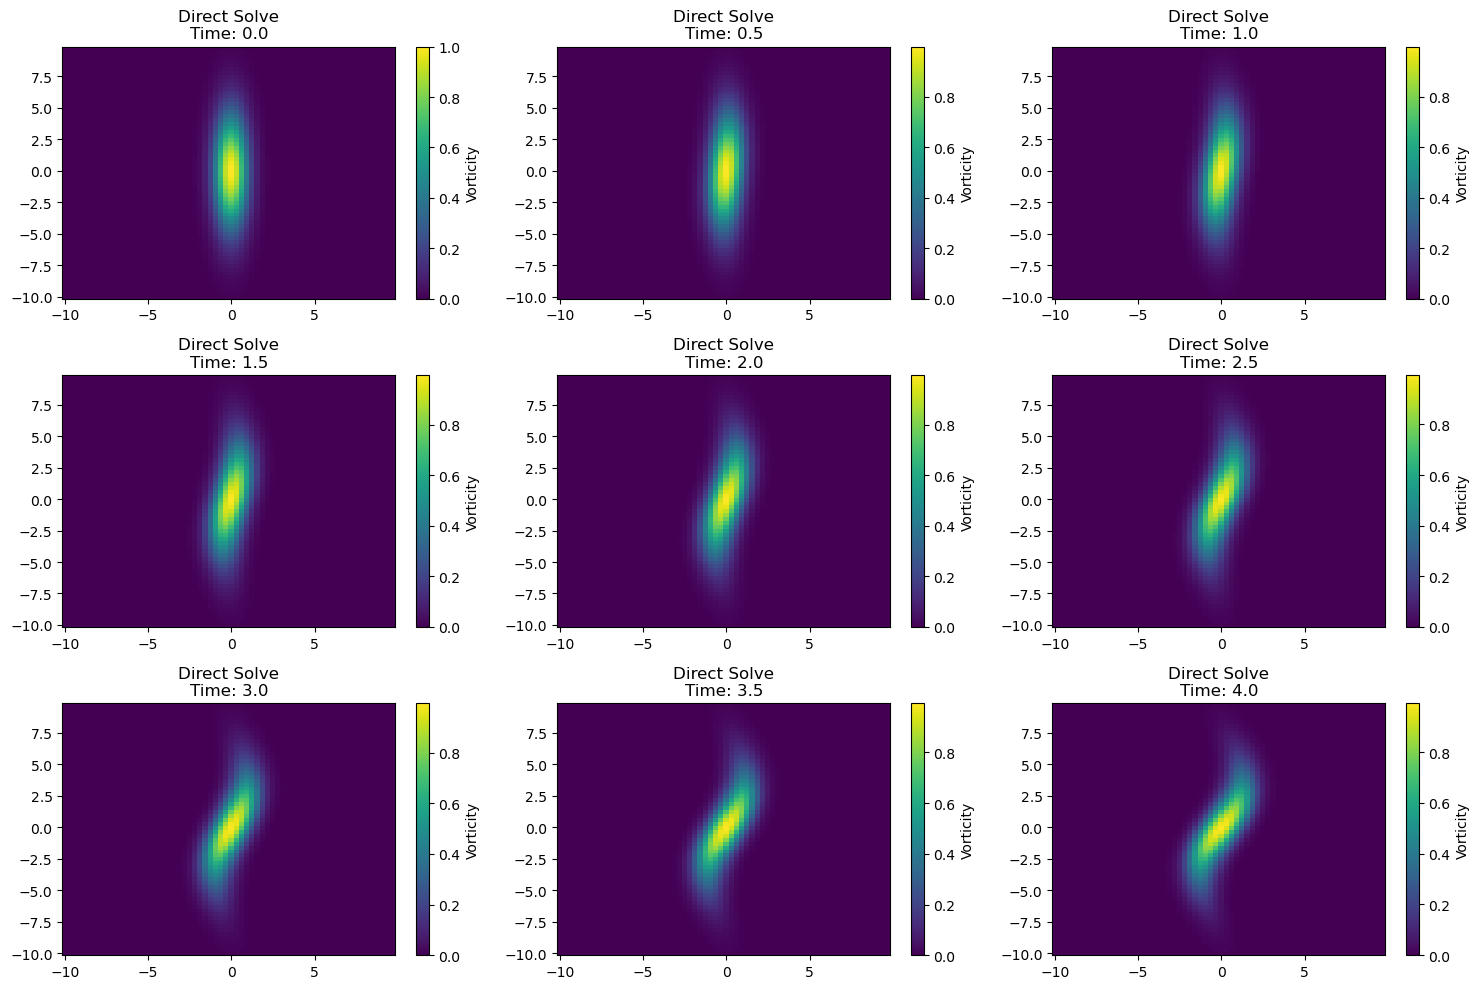

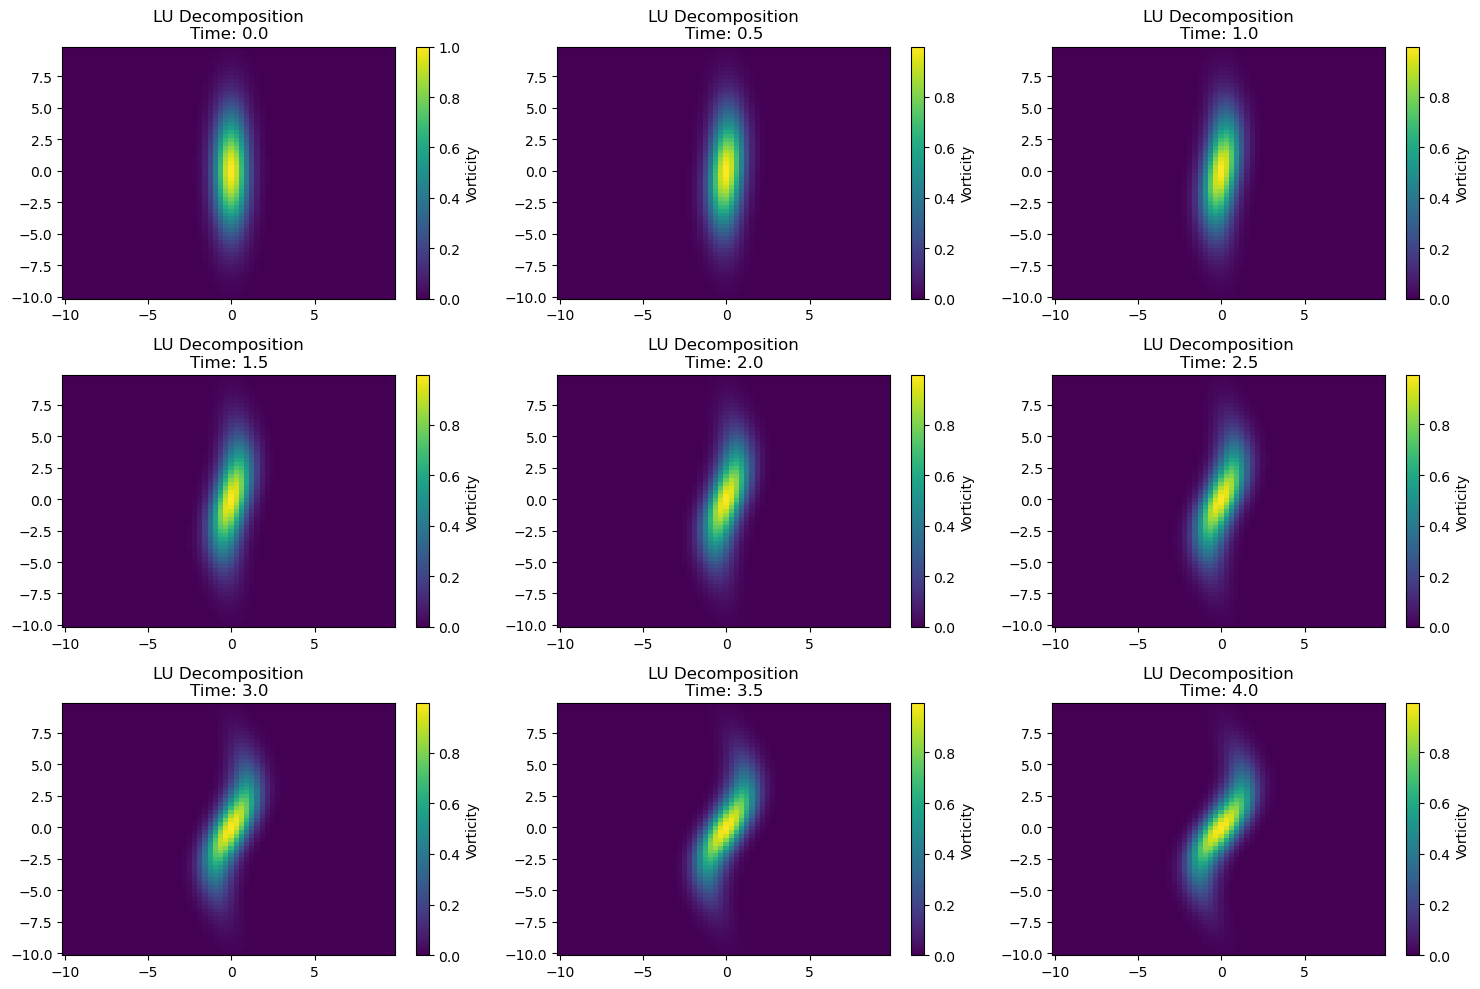

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.integrate import solve_ivp
from scipy.fft import fft2, ifft2, fftfreq
from scipy.sparse.linalg import spsolve, bicgstab, gmres
from scipy.linalg import lu, solve_triangular
import time

m = 64
n = m * m
dn = 20 / m

e0 = np.zeros((n, 1))
e1 = np.ones((n, 1))
e2 = np.copy(e1)
e4 = np.copy(e0)

for j in range(1, m+1):
    e2[m*j-1] = 0
    e4[m*j-1] = 1

e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

diagonals = [e1.flatten(), e1.flatten(), e5.flatten(),
             e2.flatten(), -4 * e1.flatten(), e3.flatten(), 
             e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)] 

A = spdiags(diagonals, offsets, n, n).toarray()
A = A / (dn**2)

adds = (1 / (2 * dn)) * np.ones((n, 1))
subs = -adds
diagonals_B = [adds.flatten(), adds.flatten(), subs.flatten(), subs.flatten()]
offsets_B = [m, -(n - m), (n - m), -m]
B = spdiags(diagonals_B, offsets_B, n, n).toarray()

diagonals_C = [e5.flatten(), -e2.flatten(), e3.flatten(), -e4.flatten()]
offsets_C = [-(m - 1), -1, 1, (m - 1)]
C = spdiags(diagonals_C, offsets_C, n, n).toarray()
C = C * (1 / (2 * dn))

A[0, 0] = 2 / (dn**2)
tspan = np.arange(0, 4.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

x2 = np.linspace(-Lx / 2, Lx / 2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly / 2, Ly / 2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w0 = np.exp(-X**2 - Y**2 / 20).flatten()

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx / 2), np.arange(-nx / 2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny / 2), np.arange(-ny / 2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

def rhsvs1(t, wt2, nx, ny, N, KX, KY, K, nu):
    w = wt2.reshape((nx, ny))
    wt = fft2(w)

    # Compute the stream function
    psit = -wt / K
    psi = np.real(ifft2(psit)).reshape(N)

    # Compute the derivatives and update
    dwdt = -(B @ psi) * (C @ wt2) + (C @ psi) * (B @ wt2) + nu * (A @ wt2)
    return dwdt

def rhsvs2_direct(t, wt2, nx, ny, A, B, C, nu):
    psi = np.linalg.solve(A, wt2)
    dwdt = -(B @ psi) * (C @ wt2) + (C @ psi) * (B @ wt2) + nu * (A @ wt2)
    return dwdt

def rhsvs2_lu(t, wt2, nx, ny, P, L, U, B, C, nu):
    Pb = np.dot(P, wt2)
    y = solve_triangular(L, Pb, lower=True)  # Solving L * y = P * wt2
    psi = solve_triangular(U, y)  # Solving U * psi = y
    dwdt = -(B @ psi) * (C @ wt2) + (C @ psi) * (B @ wt2) + nu * (A @ wt2)
    return dwdt

sol_fft = solve_ivp(lambda t, w: rhsvs1(t, w, nx, ny, N, KX, KY, K, nu), [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')
sol_direct = solve_ivp(lambda t, w: rhsvs2_direct(t, w, nx, ny, A, B, C, nu), [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')
P, L, U = lu(A)
sol_lu = solve_ivp(lambda t, w: rhsvs2_lu(t, w, nx, ny, P, L, U, B, C, nu), [tspan[0], tspan[-1]], w0, t_eval=tspan, method='RK45')

solutions = [sol_fft, sol_direct, sol_lu]
titles = ["FFT Method", "Direct Solve", "LU Decomposition"]

A1 = sol_fft.y
A2 = sol_direct.y
A3 = sol_lu.y

print("A1:", A1)
print("A2:", A2)
print("A3:", A3)

plt.figure(figsize=(15, 10))
num_time_steps = len(tspan)
num_cols = 3
num_rows = -(-num_time_steps // num_cols)  # Ceiling division

for i, (sol, title) in enumerate(zip(solutions, titles)):
    plt.figure(figsize=(15, 10))
    for j, t in enumerate(tspan):
        w = sol.y[:, j].reshape((nx, ny))  # Reshape correctly from the solution array
        plt.subplot(num_rows, num_cols, j + 1)
        plt.pcolor(x, y, w, shading='auto', cmap='viridis')
        plt.title(f'{title}\nTime: {t:.1f}')
        plt.colorbar(label='Vorticity')

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from scipy.fft import fft2, ifft2

# Define domain and simulation parameters
max_time = 60
dt = 0.5
k = 64  # Grid size
tspan = np.arange(0, max_time + dt, dt)
dn = 20 / k
Lx, Ly = 20, 20  # Domain size
nu = 0.001  # Viscosity

# Grid and Fourier modes
x = np.linspace(-Lx / 2, Lx / 2, k)
y = np.linspace(-Ly / 2, Ly / 2, k)
X, Y = np.meshgrid(x, y)
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, k / 2), np.arange(-k / 2, 0)))
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, k / 2), np.arange(-k / 2, 0)))
kx[0], ky[0] = 1e-6, 1e-6  # Avoid division by zero
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2  # Wavenumber magnitude squared

# Function for the right-hand side of the vorticity equation
def rhsvs1(t, wt, KX, KY, K, nu):
    w = wt.reshape((k, k))
    wt_hat = fft2(w)

    # Compute stream function in Fourier space
    psi_hat = -wt_hat / K
    psi = np.real(ifft2(psi_hat))

    # Compute derivatives in physical space
    dwdx = np.real(ifft2(1j * KX * wt_hat))
    dwdy = np.real(ifft2(1j * KY * wt_hat))
    dpsidx = np.real(ifft2(1j * KX * psi_hat))
    dpsidy = np.real(ifft2(1j * KY * psi_hat))

    # Vorticity equation
    dwdt = -(dpsidx * dwdy - dpsidy * dwdx) + nu * np.real(ifft2(-K * wt_hat))
    return dwdt.flatten()

# Function to run the simulation and create animations
def run_simulation(winit, file_name):
    solution = solve_ivp(
        lambda t, w: rhsvs1(t, w, KX, KY, K, nu),
        [tspan[0], tspan[-1]],
        winit.flatten(),
        t_eval=tspan,
        method='RK45',
    )

    # Prepare frames for animation
    frames = [solution.y[:, i].reshape(k, k) for i in range(len(solution.t))]

    # Set up animation
    fig, ax = plt.subplots()
    pcm = ax.pcolormesh(X, Y, frames[0], shading="auto", cmap="viridis")
    plt.colorbar(pcm, ax=ax)

    def update(frame):
        pcm.set_array(frame.ravel())
        return [pcm]

    ani = animation.FuncAnimation(fig, update, frames=frames, blit=True)
    ani.save(file_name, writer="pillow", fps=10)  # Save as GIF using Pillow
    plt.close(fig)  # Close the figure after saving
    print(f"Animation saved as {file_name}")

# Simulation 1: Two oppositely charged vortices
winit1 = 0.5 * np.exp(-(X)**2 - (Y + 1)**2) - 0.5 * np.exp(-(X)**2 - (Y - 1)**2)
run_simulation(winit1, "m1.gif")

# Simulation 2: Two same charged vortices
winit2 = 1.0 * np.exp(-(X - 0.5)**2 - (Y + 2)**2) + 0.9 * np.exp(-(X + 0.5)**2 - (Y - 2)**2)
run_simulation(winit2, "m2.gif")

# Simulation 3: Two pairs of oppositely charged vortices set to collide
winit3 = (
    1.2 * np.exp(-(X - 2)**2 - (Y + 1)**2)  # Positive vortex 1
    - 1.0 * np.exp(-(X + 2)**2 - (Y + 1)**2)  # Negative vortex 1
    + 1.0 * np.exp(-(X - 2)**2 - (Y - 1)**2)  # Positive vortex 2
    - 1.2 * np.exp(-(X + 2)**2 - (Y - 1)**2)  # Negative vortex 2
)
run_simulation(winit3, "m3.gif")

# Simulation 4: Random assortment of vortices
np.random.seed(42)
num_vortices = 15
strengths = np.random.uniform(-1.5, 1.5, num_vortices)  # Random strengths
positions = np.random.uniform(-Lx / 2, Lx / 2, (num_vortices, 2))  # Random positions
ellipticity = np.random.uniform(1, 3, num_vortices)  # Random ellipticity factors

winit4 = np.zeros_like(X)
for i in range(num_vortices):
    x0, y0 = positions[i]
    strength = strengths[i]
    ellipse_factor = ellipticity[i]
    winit4 += strength * np.exp(-((X - x0)**2 + ellipse_factor * (Y - y0)**2))

run_simulation(winit4, "m_random.gif")

Animation saved as m1.gif
Animation saved as m2.gif
Animation saved as m3.gif
